In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import matplotlib.dates as mdates

%matplotlib inline

In [2]:
basedir = 'data/P3_2017/LGS'
infile = 'OIB_P3_F2004_exportfromGeosoft.csv'
df = pd.read_csv(os.path.join(basedir, infile))
df.head()

,Line,AccBiasX,AccBiasY,AccBiasZ,AccBiasZ_mgal,Corrected_Free_Air_DgS,diff_att_noatt,diff_oib_grav4,diff_oib_grav4_70,diff_oib_grav4_70_clip,...,Pitch,Roll,seconds,static_en,static_st,unixtime,UTCDate,x,y,zbias_corr
0,D2004,0.001061,-0.000818,0.000148,14.802300,135.075,-6.467250,-4.754357,-5.951157,-5.951157,...,2.716135,0.997376,39704,15,10.6,1490612504,2017/03/27,-589235.774464,-1.341858e+06,9.202300
1,D2004,0.001062,-0.000807,0.000150,15.046800,135.476,-10.193762,-1.134118,-5.434893,-5.434893,...,4.029933,1.909525,39705,15,10.6,1490612505,2017/03/27,-589311.512068,-1.341833e+06,9.446630
2,D2004,0.001064,-0.000797,0.000151,15.149900,135.846,-12.889311,2.047225,-4.475575,-4.475575,...,5.115871,2.401810,39706,15,10.6,1490612506,2017/03/27,-589387.817282,-1.341808e+06,9.549560
3,D2004,0.001063,-0.000790,0.000153,15.250299,136.185,-13.240284,2.768039,-3.642870,-3.642870,...,5.095973,2.711225,39707,15,10.6,1490612507,2017/03/27,-589464.406190,-1.341782e+06,9.649790
4,D2004,0.001063,-0.000784,0.000155,15.533800,136.491,-10.489346,0.086192,-2.936101,-2.936101,...,4.105128,2.071890,39708,15,10.6,1490612508,2017/03/27,-589541.265709,-1.341756e+06,9.933121


In [3]:
df.keys()

Index(['Line', 'AccBiasX', 'AccBiasY', 'AccBiasZ', 'AccBiasZ_mgal',
       'Corrected_Free_Air_DgS', 'diff_att_noatt', 'diff_oib_grav4',
       'diff_oib_grav4_70', 'diff_oib_grav4_70_clip', 'diff_oib_grav4_70_corr',
       'diff_oib_grav4_clip', 'diff_oib_zbias', 'diff_oib_zbias_clip', 'drift',
       'drift_correction', 'duration', 'Ellipsoidal_height', 'Free_Air_DgS',
       'grav', 'grav4', 'grav4_70', 'grav4_70_st', 'grav_4_70_corr',
       'grav_4_corr', 'H_Ell', 'Heading', 'hms', 'imu_temp_C', 'increment',
       'Latitude', 'Longitude', 'NS', 'oib_10_11_12', 'PDOP', 'Pitch', 'Roll',
       'seconds', 'static_en', 'static_st', 'unixtime', 'UTCDate', 'x', 'y',
       'zbias_corr'],
      dtype='object')

In [4]:
df['datestring'] = pd.to_datetime(df['unixtime'],unit='s')
df = df.set_index(pd.to_datetime(df['unixtime'],unit='s'))

Text(0,0.5,'$mGal$')

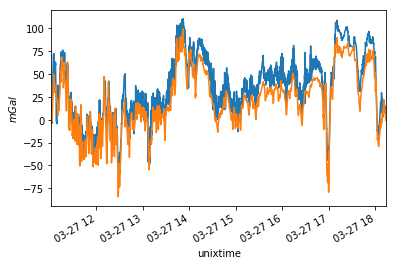

In [278]:
fig, ax = plt.subplots()
df['grav4'].plot()
df['oib_10_11_12'].plot()
ax.set_ylabel('$mGal$')

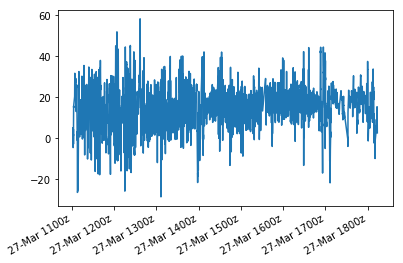

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(df['grav4'] - df['oib_10_11_12'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H%Mz'))
fig.autofmt_xdate()

No handles with labels found to put in legend.


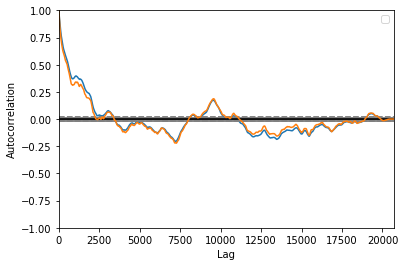

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['grav4'])
# autocorrelation_plot(df['grav_4_70_corr'])
autocorrelation_plot(df['oib_10_11_12'])
plt.legend()
plt.show()

Text(0,0.5,'$^{\\circ}C$')

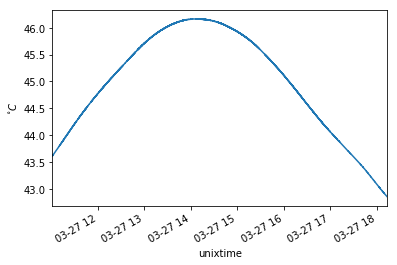

In [280]:
fig, ax = plt.subplots()
df['imu_temp_C'].plot()
ax.set_ylabel('$^{\circ}C$')

In [9]:
begin_line = datetime(2017, 3, 27, 15, 35)
end_line = datetime(2017, 3, 27, 16, 50)

Text(0,0.5,'$mGal$')

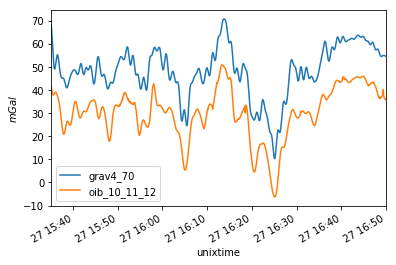

In [282]:
fig, ax = plt.subplots()
# gravity = gravity[(begin_line <= gravity.index) & (gravity.index <= end_line)]
df[['grav4_70', 'oib_10_11_12']].loc[begin_line: end_line].plot(ax=ax)
ax.set_ylabel('$mGal$')

In [11]:
df['imar_bias'] = df['grav4_70'] - df['oib_10_11_12']

Text(0,0.5,'$mGal$')

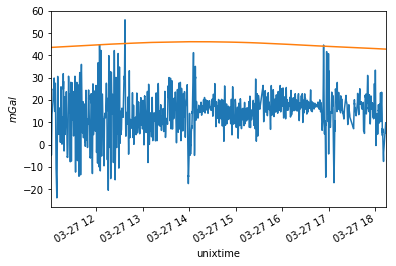

In [283]:
fig, ax = plt.subplots()
# df['imar_bias'].loc[begin_line: end_line].plot()
df['imar_bias'].plot()
df['imu_temp_C'].plot()
ax.set_ylabel('$mGal$')



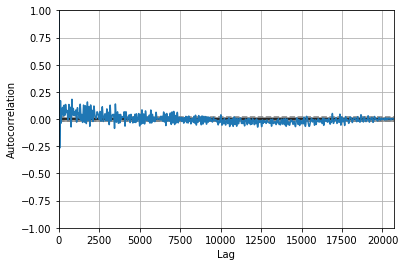

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['imar_bias'])
plt.show()

## LOWESS
Need to adjust "frac" in the lowess module to get a compatible, linear relationship.

In [248]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = df['seconds']
y = df['imar_bias']

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.6)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(4000000)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)

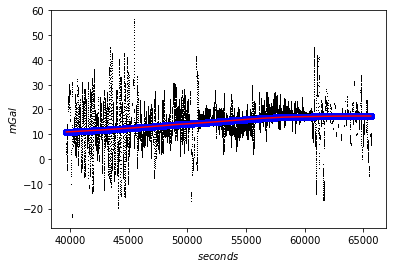

In [277]:
fig, ax = plt.subplots()
plt.plot(x, y, 'k,')
plt.plot(lowess_x, lowess_y, 'bo')
plt.plot(xnew, ynew, 'r-')
ax.set_xlabel('$seconds$')
ax.set_ylabel('$mGal$')
plt.show()

In [251]:
df['imar_bias_lowess'] = lowess_y

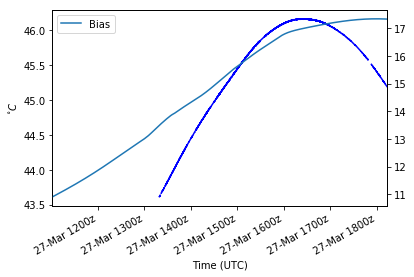

In [252]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# # For a third trace
# ax2, ax3 = ax.twinx(), ax.twinx()
# rspine = ax3.spines['right']
# rspine.set_position(('axes', 1.25))
# ax3.set_frame_on(True)
# ax3.patch.set_visible(False)
# fig.subplots_adjust(right=0.75)

df['imu_temp_C_shift'].plot(ax=ax, style='b-', label='Temp')
ax.set_ylabel('$^{\circ}C$')
df['imar_bias_lowess'].plot(ax=ax2, secondary_y=True, label='Bias')
ax2.set_ylabel('$mGal$')
ax.set_xlabel('Time (UTC)')
# df['imar_bias'].plot(ax=ax3, style='g-', alpha=0.2)
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H%Mz'))
fig.autofmt_xdate()


### Shift the IMU temps
First find the offset in peaks (better to do this objectively using CC)

In [253]:
lag_argmax = df['imar_bias_lowess'].argmax() - df['imu_temp_C'].argmax()
print(lag_argmax)

0 days 03:53:00


Test shifting by max offset

Text(0,0.5,'$^{\\circ}C$')

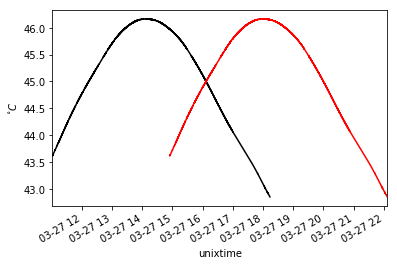

In [271]:
# df['imu_temp_C'].shift(2000).plot(color='blue')
fig, ax = plt.subplots()
df['imu_temp_C'].shift(0).plot(color='black')
df['imu_temp_C'].shift(periods=1, freq=lag_argmax).plot(color='red')
ax.set_ylabel('$^{\circ}C$')


Text(0,0.5,'$mGal$')

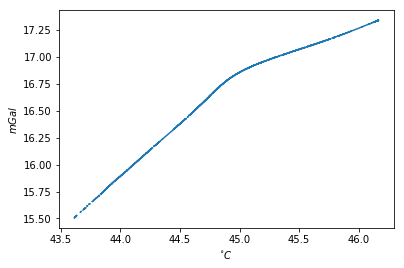

In [268]:
df['imu_temp_C_shift'] = df['imu_temp_C'].shift(periods=1, freq=lag_argmax)
# plt.plot(df['imu_temp_C'].shift(periods=1, freq=lag_argmax), df['imar_bias'])
fig, ax = plt.subplots()
plt.plot(df['imu_temp_C_shift'], df['imar_bias_lowess'])
ax.set_xlabel('$^{\circ}C$')
ax.set_ylabel('$mGal$')

Text(0,0.5,'$mGal$')

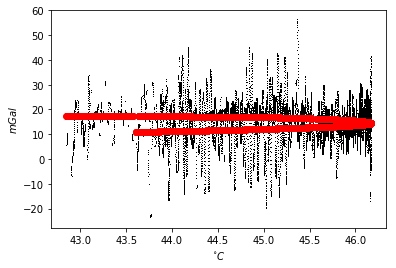

In [275]:
fig, ax = plt.subplots()
plt.plot(df['imu_temp_C'], df['imar_bias'], 'k,')
plt.plot(df['imu_temp_C'], df['imar_bias_lowess'],'ro')
ax.set_xlabel('$^{\circ}C$')
ax.set_ylabel('$mGal$')

Pandas correlation

In [286]:
# df[['imu_temp_C', 'imar_bias']].corr()
print(df.corr()['imar_bias_lowess'].tail())

y                   0.234498
zbias_corr          0.426175
imar_bias           0.230507
imar_bias_lowess    1.000000
imu_temp_C_shift    0.974393
Name: imar_bias_lowess, dtype: float64


## Linear Regression

In [262]:
import statsmodels.api as sm
# result = sm.ols(formula="A ~ B + C", data=df).fit()
# result = sm.ols(formula="imar_bias ~ imu_temp_C", data=df).fit()
ols = sm.OLS(df.imar_bias_lowess, df.imu_temp_C_shift).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:       imar_bias_lowess   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 22 May 2018   Prob (F-statistic):                nan
Time:                        11:54:09   Log-Likelihood:                    nan
No. Observations:               20691   AIC:                               nan
Df Residuals:                   20691   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
imu_temp_C_shift        nan        nan  

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


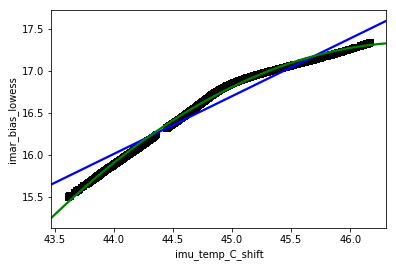

In [260]:
import seaborn as sns
# Generate a scatter plot of 'weight' and 'mpg' using red circles
plt.scatter(df['imu_temp_C_shift'], df['imar_bias_lowess'], label='data', color='black', marker=',')

# Plot in blue a linear regression of order 1 between 'weight' and 'mpg'
sns.regplot(x='imu_temp_C_shift', y='imar_bias_lowess', data=df, 
            order=1, 
            color='blue', scatter=None, label='order 1')

# Plot in green a linear regression of order 2 between 'weight' and 'mpg'
sns.regplot(x='imu_temp_C_shift', y='imar_bias_lowess', data=df, 
            order=2, 
            color='green', scatter=None, label='order 2')

# APPENDIX
1) ARIMA

2) Read in IMU temps directly

3) Testing a Lead-lag cross-correlation

### ARIMA
DEAD END (for now)

In [14]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 70) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 70)
SARIMAX: (0, 0, 1) x (0, 1, 0, 70)
SARIMAX: (0, 1, 0) x (0, 1, 1, 70)
SARIMAX: (0, 1, 0) x (1, 0, 0, 70)


In [ ]:
# import warnings

# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df['imar_bias'],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

ARIMA(0, 0, 0)x(0, 0, 1, 70)12 - AIC:167043.8128228297
ARIMA(0, 0, 0)x(0, 1, 1, 70)12 - AIC:144757.4777328421
ARIMA(0, 0, 0)x(1, 0, 0, 70)12 - AIC:159457.43178702903
ARIMA(0, 0, 0)x(1, 0, 1, 70)12 - AIC:145249.93343641347
ARIMA(0, 0, 0)x(1, 1, 0, 70)12 - AIC:154653.90547920755


In [15]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(df['imar_bias'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 70),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9009      0.003    346.870      0.000       0.896       0.906
ma.L1         -0.6997      0.003   -240.854      0.000      -0.705      -0.694
ar.S.L70      -0.7410      0.002   -348.360      0.000      -0.745      -0.737
ma.S.L70       0.7700      0.002    398.829      0.000       0.766       0.774
sigma2         0.5879      0.000   1569.436      0.000       0.587       0.589


/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


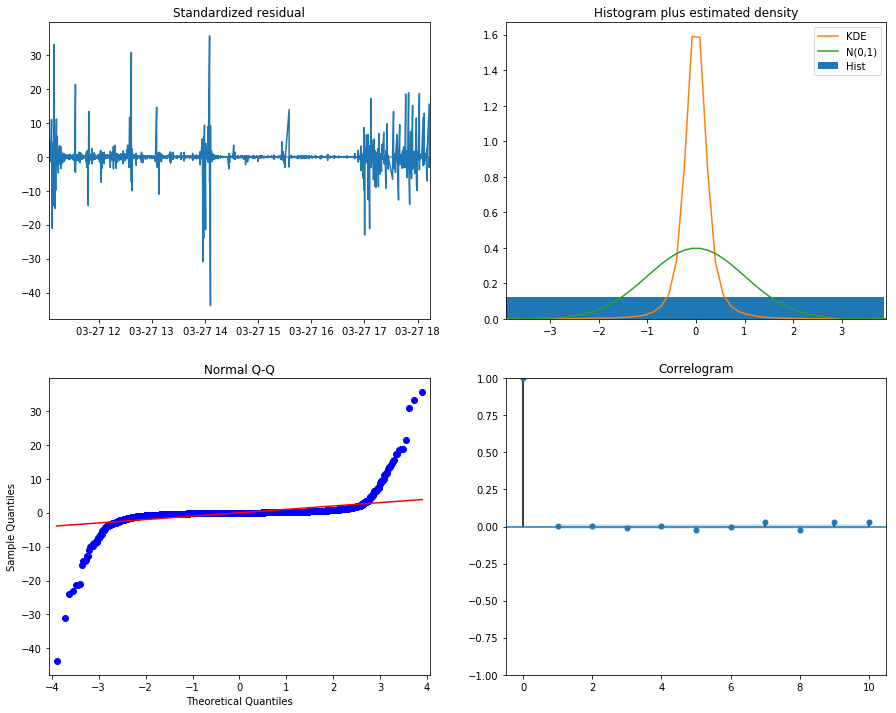

In [16]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## read RAW IMU temps

In [27]:
basedir = 'data/P3_2017/LGS/imu_temps/'
infile = 'OIB-P3_20170327_F2004_IMUTEMPS_095751.csv'
df_temp = pd.read_csv(os.path.join(basedir, infile))
df_temp.head()

,unix_utc,imu_temp_C
0,1.490609e+09,42.613
1,1.490609e+09,42.611
2,1.490609e+09,42.614
3,1.490609e+09,42.613
4,1.490609e+09,42.613


In [28]:
df_temp = df_temp.set_index(pd.to_datetime(df_temp['unix_utc'],unit='s'))
df_temp.head()

,unix_utc,imu_temp_C
unix_utc,,
2017-03-27 09:57:50.903,1.490609e+09,42.613
2017-03-27 09:57:51.903,1.490609e+09,42.611
2017-03-27 09:57:52.903,1.490609e+09,42.614
2017-03-27 09:57:53.903,1.490609e+09,42.613
2017-03-27 09:57:54.903,1.490609e+09,42.613


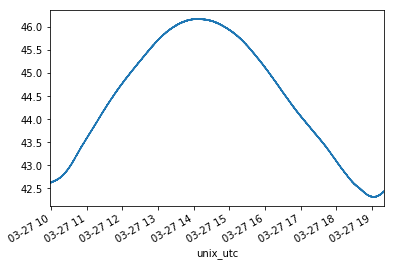

In [30]:
df_temp['imu_temp_C'].plot()

## Lead-lag correlation function

In [ ]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print '\n#<lagcorr>: Computing lagged-correlations at lags:',lag

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result
